In [4]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sigpy as sp
import sigpy.plot as pl
from scipy import signal

# BPT processing tools
bpt_path = "/mikRAID/sanand/pilot_tone/bpt/util"
sys.path.append(bpt_path)
import bpt_processing as proc
import cfl
from bart import bart

# Registration tools
import SimpleITK as sitk
sys.path.append('/mikRAID/sanand/pilot_tone/head_motion/code/bpt_code')
from util.image_registration import RigidRegistration

In [32]:
def test_reg(fixed_img, moving_img, rot_center, reg_outdir=None, debug=False, fixed_mask=None):
    # perform registration and extract results
    ndyn = moving_img.shape[0]
    transform_parameters = np.zeros((ndyn, 3))
    result_img = np.zeros(moving_img.shape)
    fixed_img = sitk.GetImageFromArray(fixed_img)

    # because the top of the y-axis is negative, and the left of the x-axis is negative in the grid, the grid rotates around the point below, and not around the exact center point
    # WE NEED TO FLIP THE ORDERING OF ALL COORDINATES - ELASTIX HAS A DIFFERENT ARRAY ORDERING THAN NUMPY
    parameter_map = sitk.GetDefaultParameterMap('rigid')
    rot_center = np.flip(rot_center)
    parameter_map['CenterOfRotationPoint'] = [str(x) for x in rot_center]

    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_img)
    elastixImageFilter.SetParameterMap(parameter_map)

    # Set mask
    if fixed_mask is not None:
        sitk_img = sitk.GetImageFromArray(fixed_mask)
        elastixImageFilter.SetFixedMask(sitk.Cast(sitk_img, sitk.sitkUInt8))

    if not debug:
        elastixImageFilter.LogToConsoleOff()
    
    for i in range(ndyn):
        print("Performing registration for dynamic {}/{}...".format(i, ndyn-1))
        movim = sitk.GetImageFromArray(moving_img[i,...])
        elastixImageFilter.SetMovingImage(movim)
        elastixImageFilter.Execute()
        result_img[i,...] = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
        transform_parameters[i, :] = np.asarray([float(x) for x in elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"][:]])

    # Save results
    if reg_outdir is not None:
        np.save(os.path.join(reg_outdir,'transform_params.npy'), transform_parameters)
        np.save(os.path.join(reg_outdir, 'result_img.npy'), result_img)

    return result_img, transform_parameters


def plot_reg_results(transformParameters, res=2):
    fig, ax = plt.subplots(1,2, figsize=(12, 4))
    fig.suptitle('Registration results')
    ax[0].plot(transformParameters[:, 0]/(2*np.pi)*360)
    ax[0].legend(['In-plane rotation (clockwise)'])
    ax[0].set_ylabel('Rotation angle [degrees]')
    ax[0].set_xlabel('Dynamics [#]')
    ax[1].plot(transformParameters[:, 1:]*res)
    ax[1].legend(['Translation horizontal (<-- = +)', 'Translation vertical (V = +)'])
    ax[1].set_ylabel('Displacement [mm]')
    ax[1].set_xlabel('Dynamics [#]')
    plt.show()

In [ ]:
# Load images
inpdir = "/mikRAID/sanand/pilot_tone/data/volunteer_sweep_042622/abdomen/2400_fb"
ksp = np.squeeze(cfl.readcfl(os.path.join(inpdir,"ksp")))

# Get image and crop
crop_win = 30
img = sp.ifft(ksp, axes=(0,1))
img_crop = img[crop_win:-crop_win,...]
img_crop_rss = np.rot90(sp.rss(img_crop, axes=(-1,)),3) # Rotate so chest is facing up

In [26]:
# Register images
reg_outdir = os.path.join(inpdir, "reg")
fixed_img = img_crop_rss[...,0]
moving_img = img_crop_rss.transpose([-1,0,1])
print(moving_img.shape)

cntr = np.array(img_crop.shape[1:])//2

result_img, transform_params = test_reg(fixed_img, moving_img,
                                        rot_center=cntr,
                                        reg_outdir=reg_outdir,
                                       debug=False,
                                        fixed_mask=None)

(100, 256, 196)
Performing registration for dynamic 0/99...
Performing registration for dynamic 1/99...
Performing registration for dynamic 2/99...
Performing registration for dynamic 3/99...
Performing registration for dynamic 4/99...
Performing registration for dynamic 5/99...
Performing registration for dynamic 6/99...
Performing registration for dynamic 7/99...
Performing registration for dynamic 8/99...
Performing registration for dynamic 9/99...
Performing registration for dynamic 10/99...
Performing registration for dynamic 11/99...
Performing registration for dynamic 12/99...
Performing registration for dynamic 13/99...
Performing registration for dynamic 14/99...
Performing registration for dynamic 15/99...
Performing registration for dynamic 16/99...
Performing registration for dynamic 17/99...
Performing registration for dynamic 18/99...
Performing registration for dynamic 19/99...
Performing registration for dynamic 20/99...
Performing registration for dynamic 21/99...
Perf

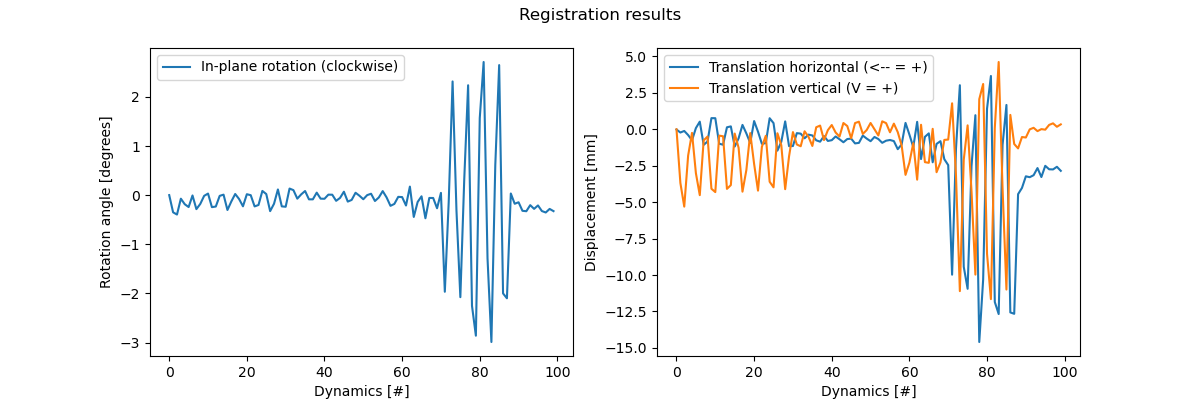

In [33]:
# Plot translation and rotation
plot_reg_results(transform_params, res=1.9)